In [27]:
import pandas as pd
import sqlite3
!pip install h5py
import h5py
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
columns = 'track_id name artist artist_id artist_mbtags year duration loudness tempo time_signature danceability energy hottness_2010 '.split()
columns += [f'chroma_{x+1}' for x in range(12)]
columns += [f'MFCC_{x+1}' for x in range(12)]
data = {c: [] for c in columns}
print(data)

{'track_id': [], 'name': [], 'artist': [], 'artist_id': [], 'artist_mbtags': [], 'year': [], 'duration': [], 'loudness': [], 'tempo': [], 'time_signature': [], 'danceability': [], 'energy': [], 'hottness_2010': [], 'chroma_1': [], 'chroma_2': [], 'chroma_3': [], 'chroma_4': [], 'chroma_5': [], 'chroma_6': [], 'chroma_7': [], 'chroma_8': [], 'chroma_9': [], 'chroma_10': [], 'chroma_11': [], 'chroma_12': [], 'MFCC_1': [], 'MFCC_2': [], 'MFCC_3': [], 'MFCC_4': [], 'MFCC_5': [], 'MFCC_6': [], 'MFCC_7': [], 'MFCC_8': [], 'MFCC_9': [], 'MFCC_10': [], 'MFCC_11': [], 'MFCC_12': []}


In [3]:
def traverse_folder(folder_path):
    
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
    progress_bar = tqdm(total=total_files, desc="Processing", unit="file")
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            with h5py.File(file_path, 'r') as file:
                analysis_group = file['analysis']
                general_analysys = analysis_group['songs'][()][0]
                musicbrainz_group = file['musicbrainz']
                metadata = file['metadata']['songs'][0]
                data['track_id'].append(general_analysys[30].decode('utf-8'))
                data['name'].append(metadata[18].decode('utf-8'))
                data['artist'].append(metadata[9].decode('utf-8'))
                data['artist_id'].append(metadata[4].decode('utf-8'))
                data['artist_mbtags'].append(f'{[x.decode("utf-8") for x in musicbrainz_group["artist_mbtags"]]}')
                data['year'].append(musicbrainz_group['songs'][0][1])
                data['duration'].append(general_analysys[3])
                data['loudness'].append(general_analysys[23])
                data['tempo'].append(general_analysys[27])
                data['time_signature'].append(general_analysys[28])
                data['hottness_2010'].append(metadata[16])
                chromas = np.mean(analysis_group['segments_pitches'][()], axis=0)
                mfcc = np.mean(analysis_group['segments_timbre'][()], axis=0)
                for n in range(12):
                    data[f'chroma_{n+1}'].append(chromas[n])
                    data[f'MFCC_{n+1}'].append(mfcc[n])
            progress_bar.update(1)
        progress_bar.close()

In [7]:
folder_path = r'/Users/maykorablina/Yandex.Disk.localized/eblan from tula/music_project/MillionSongSubset'
traverse_folder(folder_path)

Processing: 100%|██████████| 9967/9967 [00:41<00:00, 242.63file/s]


In [8]:
del data['danceability']
del data['energy']

KeyError: 'danceability'

In [9]:
df = pd.DataFrame(data)
df.to_csv(r'/Users/maykorablina/Yandex.Disk.localized/eblan from tula/music_project/music_features_new.csv')

In [10]:
df.describe()

,year,duration,loudness,tempo,time_signature,hottness_2010,chroma_1,chroma_2,chroma_3,chroma_4,...,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12
count,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,5629.000000,9967.000000,9967.000000,9967.000000,9967.000000,...,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000
mean,934.997090,238.421492,-10.476793,122.946746,3.564964,0.343186,0.438853,0.431325,0.359361,0.300387,...,12.566566,2.072704,-3.582067,-6.145601,-4.649740,-1.377385,2.988019,2.201975,-0.636457,3.005943
std,996.672653,113.804949,5.392451,35.185116,1.266896,0.247156,0.147202,0.152806,0.114556,0.109625,...,37.815504,16.714373,23.061922,14.274097,15.488125,8.162685,11.235364,6.558943,4.639514,8.579667
min,0.000000,1.044440,-51.643000,0.000000,0.000000,0.000000,0.012386,0.027143,0.029694,0.014688,...,-196.553552,-85.196147,-132.345604,-55.086545,-103.430750,-54.343608,-105.477236,-41.631664,-33.478000,-63.765014
25%,0.000000,176.417505,-13.157500,96.979500,3.000000,0.000000,0.335573,0.320562,0.282119,0.223787,...,-10.130960,-8.020631,-17.827166,-16.214388,-13.356989,-6.139233,-3.182070,-2.108553,-3.274436,-2.350826
50%,0.000000,223.137510,-9.370000,120.168000,4.000000,0.360371,0.435382,0.428033,0.352934,0.292600,...,12.780202,0.161797,-2.697471,-7.748587,-3.958792,-1.390992,3.412181,2.106735,-0.464216,2.775059
75%,2000.000000,276.218320,-6.530000,144.024000,4.000000,0.537504,0.537379,0.534902,0.430771,0.366130,...,33.496191,10.033035,10.481130,2.189983,4.895731,3.309596,9.643962,6.435797,2.102366,7.910658
max,2010.000000,1819.767710,0.566000,262.828000,7.000000,1.000000,0.975931,0.992039,0.970968,0.921784,...,308.582274,155.737215,128.885317,94.518915,114.193757,90.508778,58.093843,38.331479,30.606404,52.413890


In [11]:
df.head(5)

,track_id,name,artist,artist_id,artist_mbtags,year,duration,loudness,tempo,time_signature,...,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12
0,TRARRZU128F4253CA2,Je Sais Que La Terre Est Plate,Raphaël,AREJXK41187B9A4ACC,[],2008,148.74077,-9.636,124.059,4,...,-13.431835,-8.424728,-8.452409,-13.410788,12.765696,-1.943970,9.322297,0.077744,-1.515384,10.809157
1,TRARRJL128F92DED0E,On Efface,Julie Zenatti,AR2XRFQ1187FB417FE,[],2004,252.99546,-11.061,80.084,4,...,54.445222,0.692180,25.061545,-12.366970,-18.276061,-2.711186,1.777158,-3.809302,1.434501,12.750964
2,TRARRUZ128F9307C57,Howells Delight,The Baltimore Consort,ARODOO01187FB44F4A,[],0,78.02730,-24.140,54.874,4,...,26.853805,-13.406868,-13.894580,-2.407649,-6.070068,-9.816210,-12.092956,-5.491376,-6.591610,-0.392039
3,TRARRWA128F42A0195,Martha Served,I Hate Sally,ARJGW911187FB586CA,[],2007,163.63057,-5.795,77.150,3,...,36.705763,-1.993846,-21.519207,-27.862433,7.420505,1.130307,13.464913,6.436215,-1.811243,-9.933761
4,TRARRPG12903CD1DE9,Zip-A-Dee-Doo-Dah (Song of the South),Orlando Pops Orchestra,AR9HQ6Y1187FB3C2CB,[],0,199.99302,-16.477,120.382,4,...,27.618004,-21.010282,-2.187660,-13.019880,-22.567939,-3.464569,-0.278019,-6.784349,0.104718,7.665092


In [12]:
df_for_rec = df.drop('name	artist	artist_id	artist_mbtags	year time_signature hottness_2010 duration'.split(), axis=1)

,track_id,loudness,tempo,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,...,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12
0,TRARRZU128F4253CA2,-9.636,124.059,0.948552,0.771121,0.189315,0.219311,0.280203,0.182322,0.173269,...,-13.431835,-8.424728,-8.452409,-13.410788,12.765696,-1.943970,9.322297,0.077744,-1.515384,10.809157
1,TRARRJL128F92DED0E,-11.061,80.084,0.142478,0.391875,0.144745,0.348158,0.277078,0.105659,0.237481,...,54.445222,0.692180,25.061545,-12.366970,-18.276061,-2.711186,1.777158,-3.809302,1.434501,12.750964
2,TRARRUZ128F9307C57,-24.140,54.874,0.405902,0.270829,0.473600,0.387059,0.210527,0.248849,0.168312,...,26.853805,-13.406868,-13.894580,-2.407649,-6.070068,-9.816210,-12.092956,-5.491376,-6.591610,-0.392039
3,TRARRWA128F42A0195,-5.795,77.150,0.538966,0.549348,0.422876,0.419156,0.432793,0.454130,0.545194,...,36.705763,-1.993846,-21.519207,-27.862433,7.420505,1.130307,13.464913,6.436215,-1.811243,-9.933761
4,TRARRPG12903CD1DE9,-16.477,120.382,0.348573,0.207651,0.409202,0.338914,0.227782,0.550450,0.256027,...,27.618004,-21.010282,-2.187660,-13.019880,-22.567939,-3.464569,-0.278019,-6.784349,0.104718,7.665092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,TRBBWSE128F9313963,-6.177,142.978,0.437938,0.428727,0.529311,0.261480,0.364592,0.232225,0.258335,...,-17.601002,-8.307455,-0.871773,-6.249055,-11.471325,-0.538611,9.428526,2.422533,0.162637,1.889370
9963,TRBBWDJ128F42595D5,-14.050,94.838,0.238431,0.173234,0.273866,0.084838,0.159607,0.322369,0.179634,...,41.162145,27.554921,-10.291276,1.167962,2.738914,-16.807790,-7.570945,-5.468234,-1.229659,-0.805586
9964,TRBBWNS128F426F760,-5.802,88.344,0.511172,0.464614,0.631605,0.327503,0.349275,0.316455,0.393770,...,15.261600,-10.849456,-5.730344,-18.441436,2.943527,0.789602,-1.938429,-2.244052,-0.976286,7.911628
9965,TRBBWIP128F4287400,-11.996,160.089,0.545748,0.416689,0.255666,0.311204,0.313068,0.324270,0.296631,...,-30.284040,-4.336464,-20.369433,-4.498238,14.964450,1.087505,11.529754,1.738281,-2.679703,5.129718


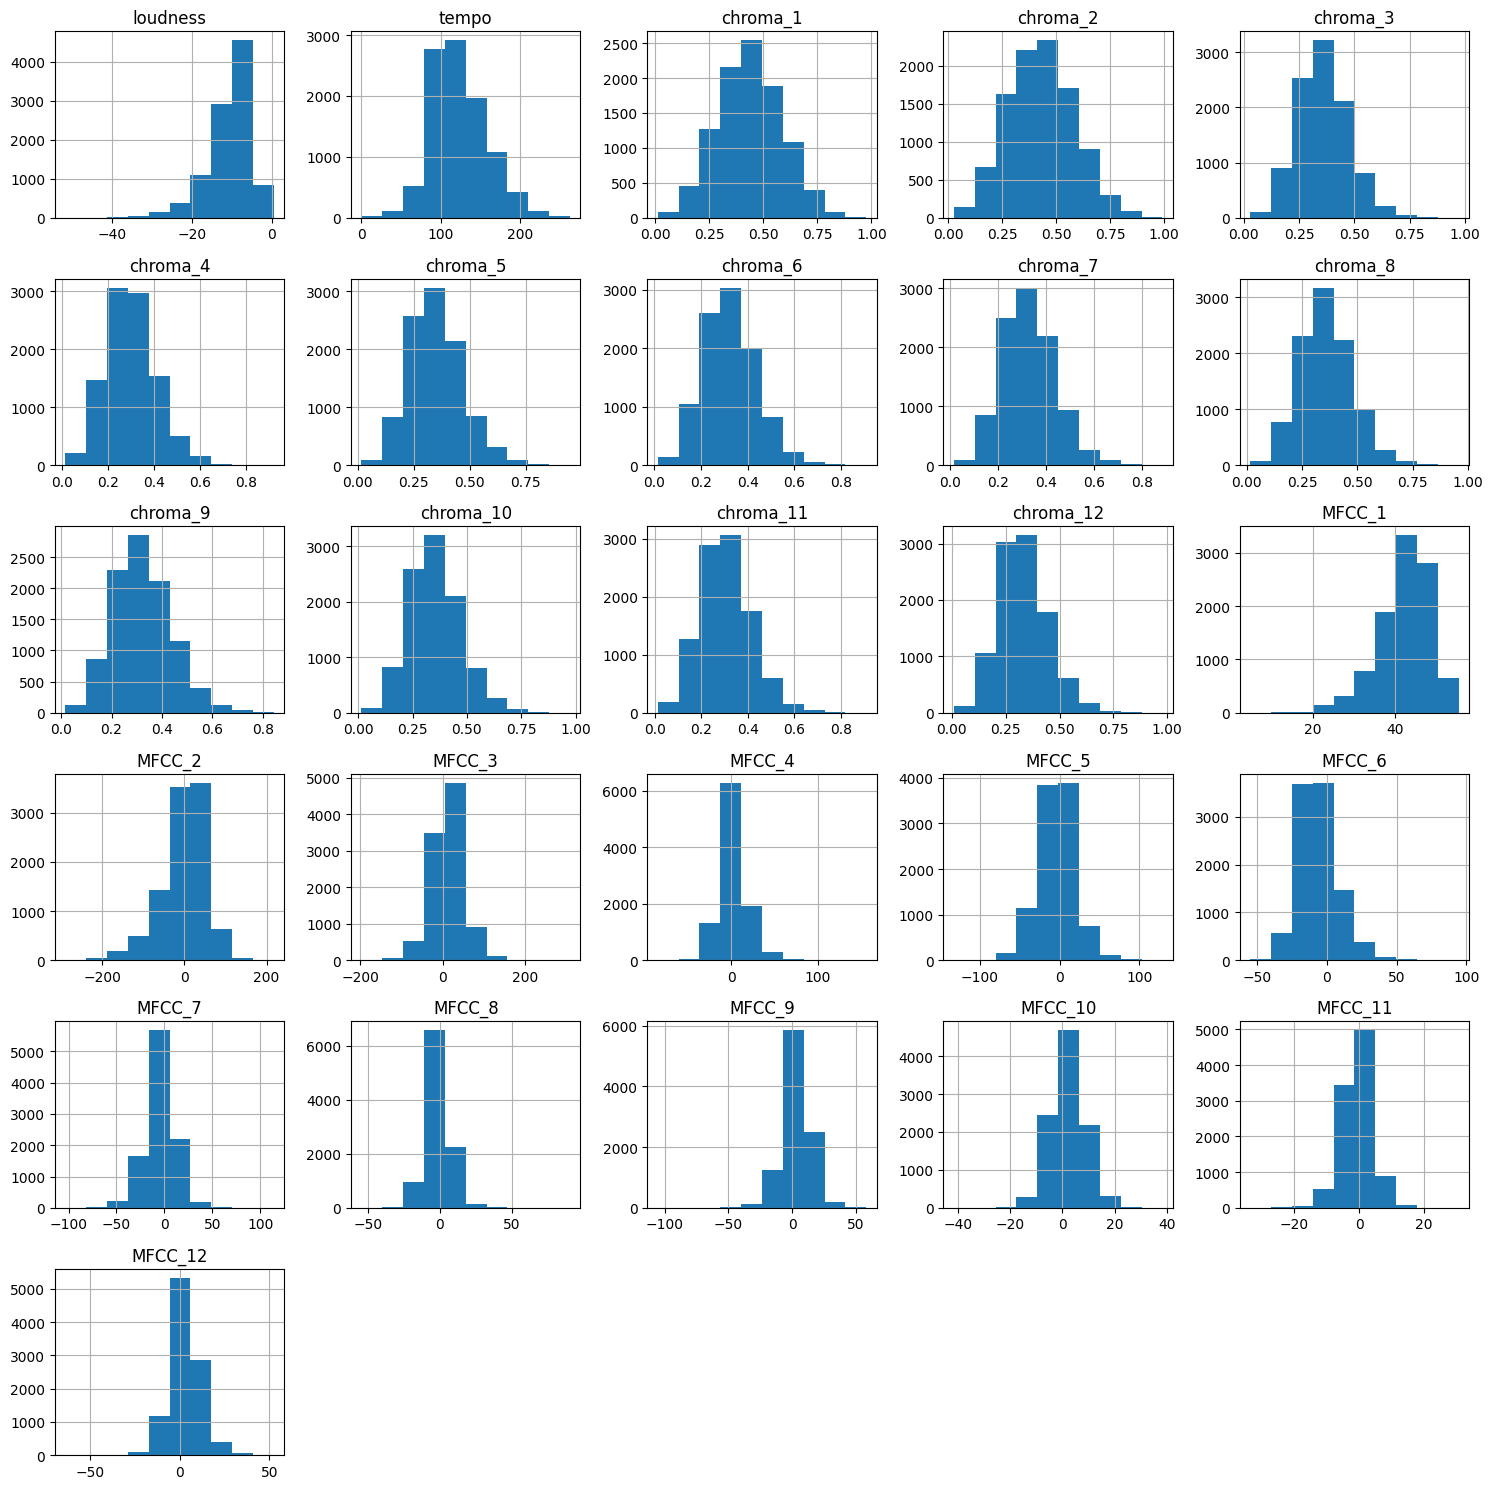

In [15]:
df_for_rec.hist(figsize=(15, 15))
plt.tight_layout()
plt.show()

C:\Users\mayko\AppData\Local\Temp\ipykernel_5964\4261880943.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_for_rec.corr()


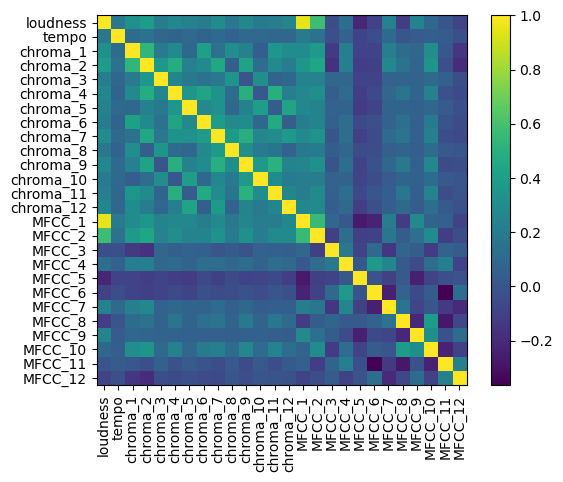

In [38]:
cor = df_for_rec.corr()
plt.imshow(cor, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(cor)), cor.columns, rotation=90)
plt.yticks(range(len(cor)), cor.columns)
plt.show()

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_for_rec.drop('track_id', axis=1))

num_clusters = 15

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_for_rec['Cluster'] = kmeans.fit_predict(scaled_data)
df_for_rec

,track_id,loudness,tempo,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,...,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,Cluster
0,TRARRZU128F4253CA2,-9.636,124.059,0.948552,0.771121,0.189315,0.219311,0.280203,0.182322,0.173269,...,-8.424728,-8.452409,-13.410788,12.765696,-1.943970,9.322297,0.077744,-1.515384,10.809157,10
1,TRARRJL128F92DED0E,-11.061,80.084,0.142478,0.391875,0.144745,0.348158,0.277078,0.105659,0.237481,...,0.692180,25.061545,-12.366970,-18.276061,-2.711186,1.777158,-3.809302,1.434501,12.750964,12
2,TRARRUZ128F9307C57,-24.140,54.874,0.405902,0.270829,0.473600,0.387059,0.210527,0.248849,0.168312,...,-13.406868,-13.894580,-2.407649,-6.070068,-9.816210,-12.092956,-5.491376,-6.591610,-0.392039,4
3,TRARRWA128F42A0195,-5.795,77.150,0.538966,0.549348,0.422876,0.419156,0.432793,0.454130,0.545194,...,-1.993846,-21.519207,-27.862433,7.420505,1.130307,13.464913,6.436215,-1.811243,-9.933761,3
4,TRARRPG12903CD1DE9,-16.477,120.382,0.348573,0.207651,0.409202,0.338914,0.227782,0.550450,0.256027,...,-21.010282,-2.187660,-13.019880,-22.567939,-3.464569,-0.278019,-6.784349,0.104718,7.665092,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,TRBBWSE128F9313963,-6.177,142.978,0.437938,0.428727,0.529311,0.261480,0.364592,0.232225,0.258335,...,-8.307455,-0.871773,-6.249055,-11.471325,-0.538611,9.428526,2.422533,0.162637,1.889370,13
9963,TRBBWDJ128F42595D5,-14.050,94.838,0.238431,0.173234,0.273866,0.084838,0.159607,0.322369,0.179634,...,27.554921,-10.291276,1.167962,2.738914,-16.807790,-7.570945,-5.468234,-1.229659,-0.805586,7
9964,TRBBWNS128F426F760,-5.802,88.344,0.511172,0.464614,0.631605,0.327503,0.349275,0.316455,0.393770,...,-10.849456,-5.730344,-18.441436,2.943527,0.789602,-1.938429,-2.244052,-0.976286,7.911628,1
9965,TRBBWIP128F4287400,-11.996,160.089,0.545748,0.416689,0.255666,0.311204,0.313068,0.324270,0.296631,...,-4.336464,-20.369433,-4.498238,14.964450,1.087505,11.529754,1.738281,-2.679703,5.129718,10


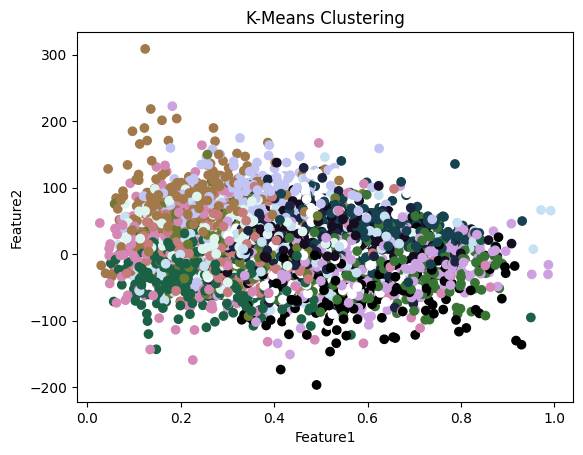

In [21]:
plt.scatter(df_for_rec['chroma_2'], df_for_rec['MFCC_3'], c=df_for_rec['Cluster'], cmap='cubehelix')
plt.title('K-Means Clustering')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

Lets look at some songs from cluster

In [26]:
df[df['track_id'].isin(df_for_rec[df_for_rec['Cluster'] == 1]['track_id'])][['name', 'artist']]

,name,artist
5,Liquid Time (composition by John Goodsall),Brand X
11,Shovel,Mistress
12,What Drives The Weak,Shadows Fall
14,The Dance Of Europe,Dave Brockie Experience
19,Playa del sous-sol,Alain-François
...,...,...
9928,No Quarter,Crowbar
9936,Another Last Shot (Album Version),Vivian
9944,Safety Net (Album Version),Moros Eros
9958,No Soy Uno Más,Jose Luis Perales


In [30]:
cosine_sim = cosine_similarity(scaled_data)

In [32]:
def most_similar_tracks(track_id):
    similar_tracks = sorted(list(enumerate(cosine_sim[track_id])), key=lambda x:x[1], reverse=True)[1:10]
    print("Рекомендации для трека", *list(df.loc[track_id][['name','artist']]), "\n-------------------------------\n")
    for index, sim in similar_tracks:
        print(*df.loc[index][['name','artist']], sim)
most_similar_tracks(94)    

Рекомендации для трека Same Old Thing Albert Collins 
-------------------------------

Cúnla/The Friar's Breeches The Chieftains;Colin James 0.6911864328115068
Take Me To Paradise (Nicky Scanni's Garage Mix) Will To Will 0.6875520885853558
Ode To Billie Joe  (Live @ Fillmore West) King Curtis 0.6842958522079029
Two Note Swivel (Unfinished Outtake) Talking Heads 0.6757075944232365
Elektro Kardiogramm (Live) Kraftwerk 0.6600483893614899
My Plastic Heart (Plastic Operator Remix) Frost 0.6415252894517078
When Your Ready Dabbler 0.641486365501202
Santa Barbara Chaka Demus & Pliers 0.6321628806697882
One Thing YZ 0.6283352267266485
